# Data Science Taxi Homework

## Introduction
- The purpose of the assignment
- Introduction to data and methods of data collection
- Page 25

## Melting
- Pages 13-15
- https://stackoverflow.com/questions/68961796/how-do-i-melt-a-pandas-dataframe
- Pickup dates

## Splitting
- Pages 16-19
- For example can have 3 tables for dates, location, and other
- Make sure each ride has the same ID

## Missing Data and Imputation
- Pages 28-42

## Outlier Detection
- Pages 52-56

## Correlation Analysis
- Page 49

        pickup_hour  pickup_month  pickup_week  pickup_doy  pickup_wday  \
0                18             5           19         132            4   
1                 7             5           21         146            4   
2                18             5           19         127            6   
3                 2             5           22         148            6   
4                17             5           21         141            6   
...             ...           ...          ...         ...          ...   
491287           23             5           21         141            6   
491288           22             5           22         151            2   
491289           19             5           19         132            4   
491290           21             5           20         140            5   
491291            7             5           20         135            7   

        length_time  pickup_BoroCode  dropoff_BoroCode  pickup_longitude  \
0               520    

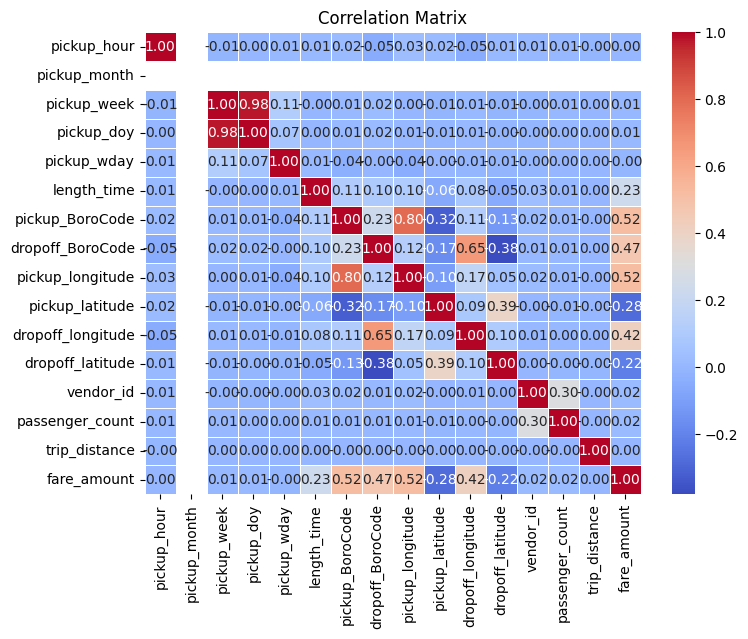

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Generate some sample data
data = pd.read_csv('data/taxi_tidy.csv')
# data = #input data here 
column_names = data.columns.tolist()

#print(column_names)
# Compute correlation matrix
##unrelated_columns = ['vendor_id']

numeric_columns = data.select_dtypes(include=['number']).columns
data_numeric = data[numeric_columns]

data_numeric = data_numeric.iloc[:, 1:]

corr_matrix = data_numeric.corr()
print(data_numeric)
# Plot correlation matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()



In this correlation matrix, one can observe some variables with high levels of correlation between each other: pickup_doy and pickup_week, is relatively self-explanatory given there is a direct mathematical correlation between week and day of the year. trip_distance and fare_amount are also strongly correlated which are again mathematically related. 

Objects of more interest: pickup_BoroCode and pickup_longitude: BoroCode is "A borough code identifying the borough in which the facility, program, or parkland property is located in", the correlation (0.80) implies there could be a mathematical causation between longitude and how the boro code was determined. However, a similar case could not be said between the code and pickup_latitude (0.32). Dropoff_borocode and dropoff_longitude similarly have a strong correlation (0.65) which is also strong evidence for a mathematical causation between the code and longitude.

Finally, fare_amount and pickup/dropoff_borocodes have a strong correlation, which could mean preset destinations that are usually further away from/to residential areas (i.e. going to/from the airport, to/from a resort/beach or an event area) have specific boro codes which attract higher fares.




## Temporal Patterns
- Plot the distribution of rides over hours, days, and weeks using histograms or line plots. Look for any unusual patterns or spikes that might indicate data quality issues or anomalies.

## Categorical Variables
- Examine the distribution of categorical variables like vendor_id, pickup_BoroCode, and dropoff_BoroCode using bar plots. Look for any unexpected or unusual categories.

## Suggested Extras
- Time Series Analysis: Conduct time series analysis on the length_time (duration of the ride) variable to identify trends, seasonality, and anomalies over time. This can involve techniques such as decomposition, autocorrelation analysis, and forecasting.

- Spatial Clustering: Apply spatial clustering algorithms like K-means or DBSCAN to group pickup and dropoff locations into clusters based on their geographical proximity. This can help identify popular pickup/dropoff zones and potential outliers.

- Network Analysis: Construct a network graph representing taxi routes between pickup and dropoff locations. Analyze the network structure to identify important nodes (locations) and potential inefficiencies in the transportation network.


## HELLO! TEST